In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
class MF(object):
    def __init__(self, Y, K, lam = 0.1, Xinit = None, Winit = None, 
    learning_rate = 0.5, max_iter = 10000, print_every = 100):
        self.Y = Y      # represents the utility matrix
        self.K = K      # number of features
        self.lam = lam  # regularization parameter
        self.learning_rate = learning_rate  # for gradient descent
        self.max_iter = max_iter            # maximum number of iterations
        self.print_every = print_every      # print loss after each a few iters
        self.n_users = int(np.max(Y[:, 0])) + 1
        self.users_ids = np.unique(np.asarray(Y[:,0].reshape(Y[:,0].shape[0])))
        self.n_items = int(np.max(Y[:, 1])) + 1
        self.items_ids = np.unique(np.asarray(Y[:,1].reshape(Y[:,1].shape[0])))
        self.n_ratings = Y.shape[0]
        self.X = np.random.randn(self.n_items, K) if Xinit is None else Xinit
        self.W = np.random.randn(K, self.n_users) if Winit is None else Winit
        self.b = np.random.randn(self.n_items)  # item biases
        self.d = np.random.randn(self.n_users)  # user biases

    # return current loss value
    def loss(self):
        L = 0
        for i in range(self.n_ratings):
            # user_id, item_id, rating
            n, m, rating = int(self.Y[i, 0]), int(self.Y[i, 1]), self.Y[i, 2]
            L += 0.5*(self.X[m].dot(self.W[:,n]) + self.b[m] + self.d[n] - rating)**2
        L /= self.n_ratings
        # regularization, don't ever forget this
        return L + 0.5*self.lam*(np.sum(self.X**2) + np.sum(self.W**2))
    
    def updateXb(self):
        for m in self.items_ids:
            ids = np.where(self.Y[:, 1] == m)[0] # row indices of items m
            user_ids, ratings = self.Y[ids, 0].astype(np.int32), self.Y[ids, 2]
            Wm, dm = self.W[:, user_ids], self.d[user_ids]
            Wm = Wm.reshape(Wm.shape[0], Wm.shape[1])
            for i in range(30): # 30 iteration for each sub problem
                xm = self.X[m]
                error = Wm.T.dot(xm).reshape(-1,1) + self.b[m] + dm - ratings
                grad_xm = Wm.dot(error)/self.n_ratings + (self.lam*xm).reshape(-1,1)
                grad_bm = np.sum(error)/self.n_ratings
                # gradient descent
                self.X[m] -= np.array((self.learning_rate*grad_xm).T)[0]
                self.b[m] -= rs.learning_rate*grad_bm

    def updateWd(self):
        for n in self.users_ids:
            # get all items rated by user n, and the corresponding ratings
            ids = np.where(self.Y[:, 0] == n)[0]
            item_ids, ratings = self.Y[ids, 1].astype(np.int32), self.Y[ids, 2]
            Xn, bn = self.X[item_ids], self.b[item_ids]
            for i in range(30): # 30 iteration for each sub problem
                wn = self.W[:, n]
                error = Xn.dot(wn) + bn + self.d[n] - ratings
                grad_wn = Xn.T.dot(error)/self.n_ratings + self.lam*wn
                grad_dn = np.sum(error)/self.n_ratings
                # gradient descent
                self.W[:, n] -= np.array(self.learning_rate*grad_wn.reshape(-1))[0]
                self.d[n]    -= self.learning_rate*grad_dn

    def fit(self):
        for it in range(self.max_iter):
            self.updateXb()
            self.updateWd()
            if (it+1) % self.print_every == 0:
                rsme_train = self.evaluate_RMSE(self.Y)
                # print("iter = ",it+1 ,", loss = "+self.loss(),", RMSE train = ",rsme_train)
                print(it+1)
                print(self.loss())
                print(rsme_train)
                print(self.evaluate_RMSE(rate_test))

    def pred(self, u, i):
        # predict the rating of user u for item i
        u, i = int(u), int(i)
        try:
            pred = self.X[i, :].dot(self.W[:, u]) + self.b[i] + self.d[u]
        except:
            return 0
        return max(0, min(5, pred))

    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2])**2
        
        RMSE = np.sqrt(SE/n_tests)
        return RMSE

In [3]:
r_cols = ['user_id', 'item_id', 'rating', 'unix_timestamp']
ratings_base = pd.read_csv('ml-100k/ua.base',sep='\t', names=r_cols)
ratings_test = pd.read_csv('ml-100k/ua.test',sep='\t', names=r_cols)

rate_train = np.asmatrix(ratings_base)
rate_test = np.asmatrix(ratings_test)

In [4]:
# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

In [6]:
rs = MF(rate_train, K = 50, lam = .01, print_every = 5, learning_rate = 50,max_iter = 30)
rs.fit()

5
0.9813242949856356
0.9576538777513495
1.0334281333969082
10
0.9517149245758885
0.927083129976136
0.9825093531726448
15
0.9439737011472505
0.9189954890904248
0.971302106084739
20
0.9407339857967102
0.9156333436753306
0.9675119236760502
25
0.9390274877027561
0.9138814638591751
0.9658114878351727
30
0.938001148320693
0.9128350514306869
0.9648862591718131


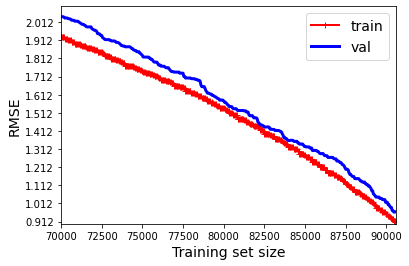

In [9]:
step = list(range(70000,90570,50))
import matplotlib.pyplot as plt
plt.plot(step,np.asarray(train_err), "r-+", linewidth=2, label="train")
plt.plot(step,np.asarray(val_err), "b-", linewidth=3, label="val")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.axis([70000, 90570, 0.9, 2.1])
plt.yticks(np.arange(min(np.asarray(train_err)), max(np.asarray(val_err)), 0.1))
plt.show()

In [13]:
rate_test.shape
rate_train.shape


(90570, 4)